<a href="https://colab.research.google.com/github/IamShivamJaiswal/sign-board/blob/master/Transliteration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Machine Translation with Attention

## Clone the repository

for data

In [1]:
!git clone https://github.com/IamShivamJaiswal/sign-board

fatal: destination path 'sign-board' already exists and is not an empty directory.


This notebook trains a sequence to sequence (seq2seq) model for Hindi to English word translation. This is an advanced example that assumes some knowledge of sequence to sequence models.

After training the model in this notebook, you will be able to input a english word, such as *"shivam"*, and return the Hindi translation: *"शिवम"*

The translation quality is reasonable for a toy example, but the generated attention plot is perhaps more interesting.

In [2]:
from __future__ import absolute_import, division, print_function

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import os
import io
import time
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import unicodedata
import re
import time

TensorFlow 2.x selected.
2.0.0-rc0


## Preprocessing

1. Add a *start* as `0` and *end* as `1` token to each sentence.
2. Clean the sentences by removing special characters.
3. Create a word index and reverse word index (dictionaries mapping from word → id and id → word).
4. Pad each sentence to a maximum length.

In [0]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = w.replace('-', ' ').replace(',', ' ')
    
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ." 
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    
    w = w.rstrip().strip()
    
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '0' + w + '1'
    return w.split()
  
def preprocess_sentence_hindi(w):
    w = unicode_to_ascii(w.lower().strip())
    w = w.replace('-', ' ').replace(',', ' ')
    
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ." 
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
        
    w = w.rstrip().strip()
    
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '0' + w + '1'
    return w.split()

In [20]:
word = "shivam"
hindi = "शिवम"
print(preprocess_sentence(word))
print(preprocess_sentence_hindi(hindi))

['0shivam1']
['0शिवम1']


In [0]:
import xml.etree.ElementTree as ET
def create_dataset(filename):

    transliterationCorpus = ET.parse(filename).getroot()
    lang1_words = []
    lang2_words = []

    for line in transliterationCorpus:
                wordlist1 = preprocess_sentence(line[0].text) # clean English words.
                wordlist2 = preprocess_sentence_hindi(line[1].text)# clean hindi words.
                
                #to check consistency in the input vs output mapping
                if len(wordlist1) != len(wordlist2):
                    print('Skipping: ', line[0].text, ' - ', line[1].text)
                    continue

                for word in wordlist1:
                    lang1_words.append(word)
                for word in wordlist2:
                    lang2_words.append(word)
    return [lang1_words,lang2_words]

In [22]:
PATH = "/content/sign-board/transliteration/data/"

train_data = create_dataset(PATH+'NEWS2012TrainingEnHi.xml')
test_data = create_dataset(PATH+'NEWS2012TestingEnHi1000.xml')

Skipping:  BUSHNELL'S MUSEUM  -  बुशनेल्स म्युज़ियम
Skipping:  I^DUKAANT  -  इंदुकांत
Skipping:  THE AUSTRALIAN/VOGEL LITERARY AWARD  -  द ऑस्ट्रेलियन/वोगेल लिट्रेरी अवार्ड
Skipping:  PLAZA 66  -  प्लाज़ा 66
Skipping:  Bhaalachan_dr  -  भालचन्द्र
Skipping:  MAN OF THE YEAR/PERSON OF THE YEAR  -  मैन ऑफ द ईयर/पर्सन ऑफ द ईयर
Skipping:  BARHARWA JUNCTION  -  बरहरवा
Skipping:  QUEEN ANNE'S WAR  -  क्वीन एनीज वार
Skipping:  STATE BNK TR  -  स्टेट बैंक ऑफ त्रावणकोर
Skipping:  IN_DRAJEET  -  इन्द्रजीत
Skipping:  SAINT FRANCIS D'ASSISI HIGH SCHOOL  -  सेंट फ्रांसिस ड‍िअस‍ीसी हाई स्कूल
Skipping:  SHU'A  -  शुआ
Skipping:  SOUTH ARLINGTON CHURCH OF CHRIST  -  साउथ अर्लिंग्टन
Skipping:  I^diyaa  -  इंडिया
Skipping:  DAI'EI  -  दैई
Skipping:  ISMA'IL  -  इस्मा'ईल
Skipping:  WOMEN'S LITERATURE PRIZE  -  वुमेन्स लिट्रेचर प्राइज़
Skipping:  KING EDWARD VII  -  किंग एडवर्ड
Skipping:  BRAJEN_DR  -  ब्रजेन्द्र
Skipping:  DIBANG VALLEY  -  दिबंगवैली
Skipping:  LU'LU  -  लु'लु
Skipping:  CHITTAR RESERVOIR-2 

In [23]:
train_data[0][:10],train_data[1][:10]

(['0raasavihaaree1',
  '0deogan',
  'road1',
  '0shatrumardan1',
  '0mahijuba1',
  '0sabine1',
  '0bill',
  'cosby1',
  '0rishta',
  'kagaz'],
 ['0रासविहारी1',
  '0दवगन',
  'रोड1',
  '0शतरमरदन1',
  '0महिजबा1',
  '0सबिन1',
  '0बिल',
  'कॉसबी1',
  '0रिशता',
  'कागज'])

In [0]:
#len(test_data[0]),len(test_data[1]),len(train_data[0])

In [0]:
#train_data[0][-1],train_data[1][-1]

In [24]:
train_data[0].extend(test_data[0])
train_data[1].extend(test_data[1])

print(len(train_data[0]),len(train_data[1]))

21382 21382


In [0]:
class WordIndex():
  def __init__(self, lang):
    self.lang = lang
    self.word2idx = {}
    self.idx2word = {}
    self.vocab = set()
    
    self.create_index()
    
  def create_index(self):
    for phrase in self.lang:
      for l in phrase:
        self.vocab.update(l)
    
    self.vocab = sorted(self.vocab)
    
    self.word2idx['<pad>'] = 0
    for index, word in enumerate(self.vocab):
      self.word2idx[word] = index + 1
    
    for word, index in self.word2idx.items():
      self.idx2word[index] = word
      

In [0]:
def tokenize(lang):
  index_lang  = WordIndex(lang)
  input_tensor = [[index_lang.word2idx[s] for s in en] for en in lang]
  max_length = max(len(t) for t in input_tensor)
  input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                                 maxlen=max_length,
                                                                 padding='post')
  return input_tensor, index_lang , max_length

In [0]:
def max_length(tensor):
    return max(len(t) for t in tensor)


def load_dataset(pairs):


    # index language using the class defined above    
    targ_lang, inp_lang = pairs[1],pairs[0]
    
    input_tensor, inp_lang_tokenizer ,max_length_inp = tokenize(inp_lang)
    
    target_tensor, targ_lang_tokenizer,max_length_tar = tokenize(targ_lang)
    
    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer,max_length_inp,max_length_tar

In [0]:
input_tensor, target_tensor, inp_lang, targ_lang,max_length_inp, max_length_targ = load_dataset(train_data)

In [0]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.idx2word[t]))

In [30]:
convert(inp_lang,input_tensor[-1])
convert(targ_lang,target_tensor[-1])

2 ----> 0
30 ----> z
13 ----> i
19 ----> o
18 ----> n
3 ----> 1
4 ----> 0
25 ----> ज
52 ----> ि
16 ----> ऑ
37 ----> न
5 ----> 1


In [31]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.05)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(20312, 20312, 1070, 1070)

In [0]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 128
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word2idx)+1
vocab_tar_size = len(targ_lang.word2idx)+1

In [0]:
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [34]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([128, 22]), TensorShape([128, 16]))

## Write the encoder and decoder model

Implement an encoder-decoder model with attention which you can read about in the TensorFlow [Neural Machine Translation (seq2seq) tutorial](https://github.com/tensorflow/nmt). This example uses a more recent set of APIs. This notebook implements the [attention equations](https://github.com/tensorflow/nmt#background-on-the-attention-mechanism) from the seq2seq tutorial. The following diagram shows that each input words is assigned a weight by the attention mechanism which is then used by the decoder to predict the next word in the sentence. The below picture and formulas are an example of attention mechanism from [Luong's paper](https://arxiv.org/abs/1508.04025v5). 

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">

The input is put through an encoder model which gives us the encoder output of shape *(batch_size, max_length, hidden_size)* and the encoder hidden state of shape *(batch_size, hidden_size)*.

Here are the equations that are implemented:

<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">

This tutorial uses [Bahdanau attention](https://arxiv.org/pdf/1409.0473.pdf) for the encoder. Let's decide on notation before writing the simplified form:

* FC = Fully connected (dense) layer
* EO = Encoder output
* H = hidden state
* X = input to the decoder

And the pseudo-code:

* `score = FC(tanh(FC(EO) + FC(H)))`
* `attention weights = softmax(score, axis = 1)`. Softmax by default is applied on the last axis but here we want to apply it on the *1st axis*, since the shape of score is *(batch_size, max_length, hidden_size)*. `Max_length` is the length of our input. Since we are trying to assign a weight to each input, softmax should be applied on that axis.
* `context vector = sum(attention weights * EO, axis = 1)`. Same reason as above for choosing axis as 1.
* `embedding output` = The input to the decoder X is passed through an embedding layer.
* `merged vector = concat(embedding output, context vector)`
* This merged vector is then given to the GRU

The shapes of all the vectors at each step have been specified in the comments in the code:

In [0]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [36]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (128, 22, 1024)
Encoder Hidden state shape: (batch size, units) (128, 1024)


In [0]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [38]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (128, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (128, 22, 1)


In [0]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)


    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [40]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((128, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (128, 60)


## Define the optimizer and the loss function

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask*1.5

  return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Training

1. Pass the *input* through the *encoder* which return *encoder output* and the *encoder hidden state*.
2. The encoder output, encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
3. The decoder returns the *predictions* and the *decoder hidden state*.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use *teacher forcing* to decide the next input to the decoder.
6. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word2idx['0']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [44]:
EPOCHS = 20

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.9161
Epoch 1 Batch 100 Loss 1.3553
Epoch 1 Loss 1.3663
Time taken for 1 epoch 82.57677459716797 sec

Epoch 2 Batch 0 Loss 1.0374
Epoch 2 Batch 100 Loss 0.4675
Epoch 2 Loss 0.6170
Time taken for 1 epoch 56.282283782958984 sec

Epoch 3 Batch 0 Loss 0.3814
Epoch 3 Batch 100 Loss 0.2745
Epoch 3 Loss 0.3060
Time taken for 1 epoch 55.651458501815796 sec

Epoch 4 Batch 0 Loss 0.2368
Epoch 4 Batch 100 Loss 0.2437
Epoch 4 Loss 0.2332
Time taken for 1 epoch 55.665244340896606 sec

Epoch 5 Batch 0 Loss 0.2277
Epoch 5 Batch 100 Loss 0.1963
Epoch 5 Loss 0.1923
Time taken for 1 epoch 55.412527322769165 sec

Epoch 6 Batch 0 Loss 0.1749
Epoch 6 Batch 100 Loss 0.1517
Epoch 6 Loss 0.1665
Time taken for 1 epoch 55.85036039352417 sec

Epoch 7 Batch 0 Loss 0.1481
Epoch 7 Batch 100 Loss 0.1352
Epoch 7 Loss 0.1499
Time taken for 1 epoch 55.6094536781311 sec

Epoch 8 Batch 0 Loss 0.1255
Epoch 8 Batch 100 Loss 0.1078
Epoch 8 Loss 0.1263
Time taken for 1 epoch 56.173123836517334 sec

Epoc

## Translate

* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

In [0]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)[0]

    inputs = [inp_lang.word2idx[i] for i in sentence]

    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word2idx['0']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.idx2word[predicted_id] + ' '

        if targ_lang.idx2word[predicted_id] == '1':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [0]:

# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [0]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence[1:-1]))
    print('Predicted translation: {}'.format(''.join(result.split(' '))[:-1]))

    attention_plot = attention_plot[:len(result.split(' ')), :len(list(sentence))]
    plot_attention(attention_plot, list(sentence), result.split(' '))
    

## Restore the latest checkpoint and test

In [49]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: shivam
Predicted translation: शिवम


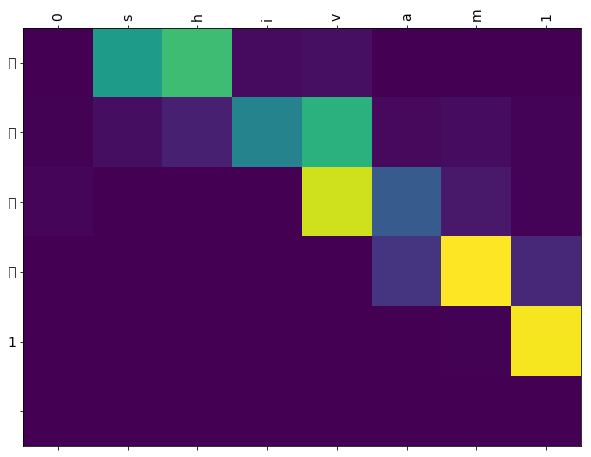

In [50]:
translate('shivam')

Input: jaiswal
Predicted translation: जसवाल


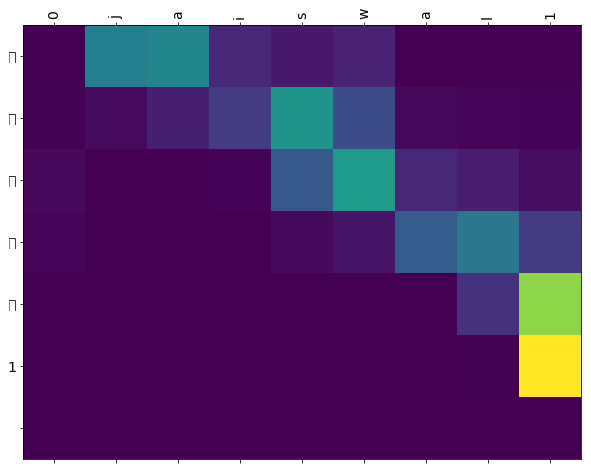

In [48]:
translate('jaiswal')

## Next steps

* [Download a different dataset](http://www.manythings.org/anki/) to experiment with translations, for example, English to German, or English to French.
* Experiment with training on a larger dataset, or using more epochs
